In [1]:
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
import numpy as np
import os

import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage  
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

import py3Dmol
from ipywidgets import interact, IntSlider


import ast
import math
import random as random
import copy
np.random.seed(7678)
from sklearn.metrics import auc, roc_curve

import matplotlib.pyplot as plt
from matplotlib import interactive
interactive(True)
import seaborn as sns
sns.set(style="whitegrid")

from IPython.display import clear_output
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [2]:
DF_CCLE = pd.read_csv('/media/ebc/F47A-25A8/PDBMap_Backup/CCLE/XYZ/GW_Full_Gene_XYZ.csv',index_col=0)

/home/ebc/anaconda3/envs/MutCat/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/ebc/anaconda3/envs/MutCat/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
len(DF_CCLE.Hugo_Symbol.unique())

5518

In [6]:
DF_clustering = pd.read_csv('/media/ebc/F47A-25A8/PDBMap_Backup/CCLE/clustering/DF_clustering_GW_merged_NRF2set.csv', index_col=0)


In [8]:
DF_clustering.head(2)

,idx1,idx2,dist,num_members,index_of_members,member_idx,group_member_idx,group_number,Tumor_Sample_Barcode,uniprotId,var_x,var_y,var_z,cluster_ID,Hugo_Symbol,structureChainId,ID
0,4.0,5.0,0.0,2.0,"[4, 5]",4,"[4, 5]",281,UMUC5_URINARY_TRACT,P19623,36.415001,19.357,1.82,c_0_,SRM,2O06.A,SRM_2O06.A_c_0_
1,4.0,5.0,0.0,2.0,"[4, 5]",5,"[4, 5]",281,MFM223_BREAST,P19623,36.415001,19.357,1.82,c_0_,SRM,2O06.A,SRM_2O06.A_c_0_


In [19]:
path_phenotype = '/home/ebc/Arkat3/phenotypes/'
file_name = 'ark_all_CCLE.csv'
pathway_name = 'NRF2/PPP'


In [20]:
target = pd.read_csv(path_phenotype+file_name, index_col=0)

sig = target.loc[pathway_name,:].sort_values(ascending = False)

sig_mean = sig.mean()
sig_std = sig.std()

sig_Act = pd.Series(np.where(sig >= sig_mean + sig_std, 1, 0), 
                     index = sig.index, name='Active_sample')

print(sig_Act.value_counts())

0    840
1    168
Name: Active_sample, dtype: int64


## Compute Probabilities

In [24]:
path_save = '/media/ebc/F47A-25A8/PDBMap_NRF2/CCLE/Arkat/Active/'

In [23]:
def create_components_df(cell_list, cluster_list, df):
    
    cluster_components = pd.DataFrame(columns=cell_list)

    for i in cluster_list:
        
        #clear_output(wait=True)
        #print(cluster_list.index(i),"out of",len(cluster_list))

        binary_list = []

        tmp = df[df.ID==i].Tumor_Sample_Barcode.unique().tolist()

        if len(tmp)>0:

            for j in cluster_components.columns:
                if j in tmp:
                    binary_list.append(1)
                else:
                    binary_list.append(0)

            cluster_components.at[i] = binary_list

    #cluster_components = cluster_components.apply(pd.to_numeric)
    return cluster_components  

In [26]:
def get_probabilities_for_clusters(NRF2_Act, cluster_components, cluster):
    
    overlap = set(NRF2_Act.index).intersection(set(cluster_components.columns))
    overlap = np.sort(list(overlap))
    df = cluster_components.loc[:, overlap]
    NRF2_Act = NRF2_Act.loc[overlap]
    
    N = len(overlap)
    
    P = pd.DataFrame()
    
    if( type(cluster)!= list):
        cluster = [cluster]
        
    for feature in cluster:
        
        name = feature
        
        c = df.loc[feature,:]
        
        if len(c[c>0])>1:

            #Marginal Probabilities 

            prob_c = pd.Series(c.value_counts()/N, name = 'prob_c')
            sum_prob_c = prob_c.sum()

            prob_Act = pd.Series(NRF2_Act.value_counts()/N, name = 'prob_Act')
            sum_prob_Act = prob_Act.sum()

            # Joint Probabilities

            joint_counts_Act_vs_c = pd.crosstab(NRF2_Act, c)
            joint_prob_Act_vs_c = joint_counts_Act_vs_c/N
            joint_prob_sum = joint_prob_Act_vs_c.sum().sum()

            Num_act_in_sample_set = joint_counts_Act_vs_c.values[1][1]
            Num_unact_in_sample_set = joint_counts_Act_vs_c.values[0][1]

            # Conditional Probability

            cond_prob_Act_given_c = joint_prob_Act_vs_c.div(prob_c, axis='columns')
            cond_prob_sum = np.mean(cond_prob_Act_given_c.sum(axis=0).values)

            try:
                cond_prob_1_1 = cond_prob_Act_given_c.values[1][1]
                cond_prob_1_0 = cond_prob_Act_given_c.values[1][0]
                cond_prob_0_0 = cond_prob_Act_given_c.values[0][0]
                cond_prob_0_1 = cond_prob_Act_given_c.values[0][1]
                
                joint_prob_1_1 = joint_prob_Act_vs_c.values[1][1]
                joint_prob_1_0 = joint_prob_Act_vs_c.values[1][0]
                joint_prob_0_0 = joint_prob_Act_vs_c.values[0][0]
                joint_prob_0_1 = joint_prob_Act_vs_c.values[0][1]
        
            except IndexError:
                print(cluster,len(c[c>0]))
                
            
            ## Odds Ratio and Risk Ratio
            # RR = (a/(a+b))/(c/(c+d))  where a is 0,0 b is 0,1 c is 1,0 d is 1,1 on the joint counts cross table
            
            d = joint_counts_Act_vs_c.values[0][0]
            b = joint_counts_Act_vs_c.values[0][1]
            c = joint_counts_Act_vs_c.values[1][0]
            a = joint_counts_Act_vs_c.values[1][1]
            
            RR = (a/(a+b))/(c/(c+d))
            
            odds = np.true_divide(a,c)
            OR = np.true_divide(np.multiply(a+.5,d+.5),np.multiply(b+.5,c+.5))
            LOR = np.log(OR)

            #ci = exp(log(or) ± Zα/2­*√1/a + 1/b + 1/c + 1/d)
            CI = 1.96*np.sqrt(np.true_divide(1,(a+.5))+np.true_divide(1,(b+.5))+np.true_divide(1,(c+.5))+np.true_divide(1,(d+.5)))
            LogCI = np.log(CI)
            
            if RR == np.inf:
                RR = 100
            if OR == np.inf:
                OR = 100
            if LOR == np.inf:
                LOR = 100
            if RR == -np.inf:
                RR = -100
            if OR == -np.inf:
                OR = -100
            if LOR == -np.inf:
                LOR = -100
                


            P = pd.concat ([P,pd.DataFrame([{'feature':name,'Num_act_in_sample_set':Num_act_in_sample_set,'Num_unact_in_sample_set':Num_unact_in_sample_set,'P(Act=1|c=1)':cond_prob_1_1,'P(Act=1|c=0)':cond_prob_1_0,'P(Act=0|c=1)':cond_prob_0_1,'P(Act=0|c=0)':cond_prob_0_0,'joint_11':joint_prob_1_1,'joint_01':joint_prob_0_1,'Risk_Ratio':RR,'Odds_Ratio':OR,'Log_Odds_Ratio':LOR,'CI_OR':CI,'Log_CI_OR':LogCI,'N':N,'prob_c':prob_c.values,'sum_prob_c':sum_prob_c,'prob_Act':prob_Act.values,'sum_prob_Act':sum_prob_Act,'joint_counts_Act_vs_c':np.round(joint_counts_Act_vs_c,decimals=3).values,'joint_prob_Act_vs_c':np.round(joint_prob_Act_vs_c,decimals=3).values,'sum_joint_prob':joint_prob_sum,'cond_prob_Act_given_c':np.round(cond_prob_Act_given_c, decimals=3).values,'sum_cond_prob':cond_prob_sum}])])
            P = P[['feature','N','Num_act_in_sample_set','Num_unact_in_sample_set','P(Act=1|c=1)','P(Act=1|c=0)','P(Act=0|c=1)','P(Act=0|c=0)','joint_11','joint_01','Risk_Ratio','Odds_Ratio','Log_Odds_Ratio','CI_OR','Log_CI_OR','cond_prob_Act_given_c','joint_prob_Act_vs_c','joint_counts_Act_vs_c','prob_Act','prob_c','sum_cond_prob','sum_joint_prob','sum_prob_Act','sum_prob_c']]
    
        else:
            pass
        
       
    if( len(cluster)>1):
        if len(P)>0:
            
            feature = P['feature'].tolist()
            Num_act_in_sample_set = P['Num_act_in_sample_set'].sum()
            Num_unact_in_sample_set = P['Num_unact_in_sample_set'].sum()
            
            ## P ( Act | c1,c2,c3...) = P(Act)*Prod(P(ci | Act))/ Prod(P(ci))
            
            cond_prob_1_1 = np.true_divide(np.prod(P['joint_11']),np.prod(P['prob_c'].values[0][1]))
            cond_prob_0_1 = np.true_divide(np.prod(P['joint_01']),np.prod(P['prob_c'].values[0][1]))
            
            C = pd.DataFrame([{'feature':feature,'Num_act_in_sample_set':Num_act_in_sample_set,'Num_unact_in_sample_set':Num_unact_in_sample_set,'P(Act=1|c=1)':cond_prob_1_1,'P(Act=1|c=0)':cond_prob_1_0,}])
            
        
        return P,C
    
    else:
        return P


In [28]:
# Gets conditional probability table across all genes

cell_list = sig_Act.index.tolist()

for gene in DF_clustering.Hugo_Symbol.unique():
    
    DF_prob = pd.DataFrame()
    
    clear_output(wait=True)
    print(DF_clustering.Hugo_Symbol.unique().tolist().index(gene),"out of",len(DF_clustering.Hugo_Symbol.unique().tolist()))
    
    df = DF_clustering[DF_clustering.Hugo_Symbol==gene]
    
    cluster_list = df.ID.unique().tolist()
    
    cluster_components = create_components_df(cell_list, cluster_list, df)
    
    cluster_components.to_csv(path_save+'Cluster_Components/cluster_components_%s.csv'%gene)
    
    for cluster in df.ID.unique():
    
        tt = get_probabilities_for_clusters(sig_Act, cluster_components, cluster)
        
        if len(tt)>0:
            DF_prob = pd.concat([DF_prob, tt])

    DF_prob.to_csv(path_save+'Probabilities/DF_Prob_%s.csv'%gene)


5407 out of 5408


In [30]:
path_prob = path_save+'Probabilities/'
entries_done = os.listdir(path_prob)
entries_done = [i for i in entries_done if i.startswith('DF_Prob')]

DF_Prob_Main = pd.DataFrame()

for f in entries_done:
    
    clear_output(wait=True)
    print(entries_done.index(f),"out of",len(entries_done))
    
    tmp = pd.read_csv(path_prob+f)
    
    try:
        tmp['Num_samples'] = tmp.Num_act_in_sample_set+ tmp.Num_unact_in_sample_set
        tmp = tmp[(tmp.Num_act_in_sample_set>2)|(tmp.Num_unact_in_sample_set>2)]
        
    except (KeyError,AttributeError):
        tmp=pd.DataFrame()
    
    if len(tmp)>0:
        DF_Prob_Main = pd.concat([DF_Prob_Main,tmp])
    
    

5407 out of 5408


In [38]:
DF_Prob_Main['Hugo_Symbol'] = [i.split('_')[0] for i in DF_Prob_Main.feature]

In [40]:
DF_Prob_Main[(DF_Prob_Main['P(Act=1|c=1)']>.7)&(DF_Prob_Main.Num_act_in_sample_set>5)].sort_values('Num_act_in_sample_set',ascending=False)[['Hugo_Symbol','P(Act=1|c=1)','Num_act_in_sample_set']].drop_duplicates()

,Hugo_Symbol,P(Act=1|c=1),Num_act_in_sample_set
218,AKR1C4,0.703704,19
143,AKR1C4,0.730769,19
68,AKR1C4,0.782609,18
203,AKR1C4,0.850000,17
200,AKR1C4,0.894737,17
63,AKR1C4,0.809524,17
49,AKR1C4,0.888889,16
40,AKR1C4,0.941176,16
21,AKR1C4,0.933333,14
1011,KEAP1,0.736842,14


In [41]:
DF_Prob_Main_dist = pd.merge(DF_Prob_Main,DF_clustering[['dist','ID']].drop_duplicates(),right_on='ID',left_on='feature')

In [42]:
DF_Prob_Main_dist.to_csv(path_save+'DF_Prob_Main_dist.csv')

In [60]:
DF_top_clusters_per_gene = pd.DataFrame()

for i in DF_Prob_Main_dist.Hugo_Symbol.unique():
    
    tmp = DF_Prob_Main_dist[(DF_Prob_Main_dist['P(Act=1|c=1)']>.7)&(DF_Prob_Main_dist.Hugo_Symbol==i)&(DF_Prob_Main_dist.dist<12)].sort_values(['Num_act_in_sample_set','Risk_Ratio'],ascending=False)
    
    DF_top_clusters_per_gene = pd.concat([DF_top_clusters_per_gene,tmp.head(1)])
    
tt = []
ss = []
rr = []

for i in DF_top_clusters_per_gene.feature.tolist():
    
    if i in DF_clustering.ID.tolist():
        tmp = DF_clustering[DF_clustering.ID==i]
        
        list_samples = tmp.Tumor_Sample_Barcode.unique().tolist()
        tt.append(len(list_samples))
        ss.append(list_samples)
    
        
DF_top_clusters_per_gene['Num_samples'] = tt
DF_top_clusters_per_gene['Sample_ID'] = ss

# normalize GSEA signature
target = (sig - sig.mean())/(sig.std())

for i in DF_top_clusters_per_gene.index:
    ll = DF_top_clusters_per_gene.ix[i,'Sample_ID']
        
    qq=[]
    for j in ll:
        
        try:
            qq.append(target[j])
        except KeyError:
            pass
    rr.append(qq)

    
DF_top_clusters_per_gene['Response_values'] = rr        
    

/home/ebc/anaconda3/envs/MutCat/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [61]:
DF_top_clusters_per_gene[(DF_top_clusters_per_gene['P(Act=1|c=1)']>.7)&(DF_top_clusters_per_gene.Num_act_in_sample_set>5)].sort_values('Num_act_in_sample_set',ascending=False)[['Hugo_Symbol','P(Act=1|c=1)','Num_act_in_sample_set']].drop_duplicates()

,Hugo_Symbol,P(Act=1|c=1),Num_act_in_sample_set
355493,AKR1C4,0.894737,17
143406,KEAP1,1.000000,8


In [62]:
DF_top_clusters_per_gene_plot = DF_top_clusters_per_gene[(DF_top_clusters_per_gene.dist<15)&(DF_top_clusters_per_gene.Num_act_in_sample_set>3)].sort_values(['Num_act_in_sample_set','Risk_Ratio'],ascending=False)[['Num_act_in_sample_set','Num_unact_in_sample_set','Hugo_Symbol','feature','P(Act=1|c=1)','dist','Num_samples','Odds_Ratio','Risk_Ratio','Log_Odds_Ratio','Log_CI_OR']].drop_duplicates()
DF_top_clusters_per_gene_plot['Num_samples_with_data']=DF_top_clusters_per_gene_plot['Num_act_in_sample_set']+DF_top_clusters_per_gene_plot['Num_unact_in_sample_set']

DF_top_clusters_per_gene_plot = pd.merge(DF_top_clusters_per_gene_plot,DF_top_clusters_per_gene[['feature','Response_values']])


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

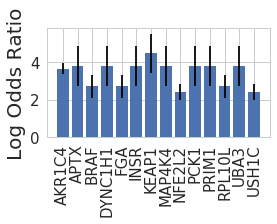

In [67]:
tt = DF_top_clusters_per_gene_plot[['Hugo_Symbol','Log_CI_OR','Log_Odds_Ratio']].sort_values('Hugo_Symbol')

size = (4,2)
fig, ax = plt.subplots(figsize=size)
ax.bar(tt['Hugo_Symbol'],tt['Log_Odds_Ratio'],yerr=tt['Log_CI_OR'])
ax.tick_params(labelsize=15)
ax.set_ylabel("Log Odds Ratio",fontsize=20)
fig = ax.get_figure()
plt.setp(ax.get_xticklabels(), rotation=90)

#fig.savefig('../analysis/NRF2/dataframes/all_NRF2_gene_set/CCLE_GW_NRF2_active_top_cluster_log_odds.pdf',format="PDF")

In [69]:
ff = []

for i in DF_top_clusters_per_gene_plot.index:
    gene = DF_top_clusters_per_gene_plot.ix[i,'Hugo_Symbol']
    ll = DF_top_clusters_per_gene_plot.ix[i,'Response_values']
    
    for j in ll:

        ff.append({'Gene':gene,'Value':float(j)})

        
test = pd.DataFrame(ff)

/home/ebc/anaconda3/envs/MutCat/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
/home/ebc/anaconda3/envs/MutCat/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


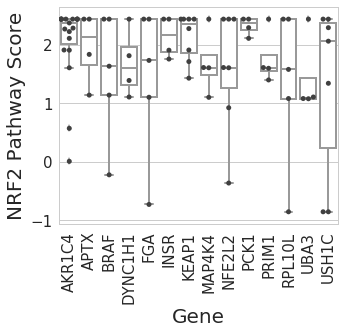

In [71]:
size = (5,4)
fig, ax = plt.subplots(figsize=size)
ax = sns.boxplot(x="Gene", y="Value", data=test.sort_values('Gene'), palette=["w"],linewidth=2)
ax = sns.swarmplot(x="Gene", y="Value", data=test.sort_values('Gene'), color=".25",size=5)
ax.tick_params(labelsize=15)
ax.set_xlabel("Gene",fontsize=20)
ax.set_ylabel("NRF2 Pathway Score",fontsize=20)

plt.setp(ax.get_xticklabels(), rotation=90)
fig = ax.get_figure()
#fig.savefig('../analysis/NRF2/dataframes/all_NRF2_gene_set/CCLE_GW_NRF2_active_top_cluster_boxplots.pdf',format="PDF")

In [74]:
DF_top_clusters_per_gene[(DF_top_clusters_per_gene['P(Act=1|c=1)']>.7)&(DF_top_clusters_per_gene.Num_act_in_sample_set>5)&(DF_top_clusters_per_gene.Hugo_Symbol=='KEAP1')].sort_values('Num_act_in_sample_set',ascending=False).Response_values.tolist()

[[1.4317792169543306,
  2.4423483453997585,
  2.4423483453997585,
  1.9134382069433962,
  2.4423483453997585,
  1.7156406784811797,
  2.280251095779384,
  2.4423483453997585]]

In [75]:
DF_top_clusters_per_gene[(DF_top_clusters_per_gene['P(Act=1|c=1)']>.7)&(DF_top_clusters_per_gene.Num_act_in_sample_set>5)&(DF_top_clusters_per_gene.Hugo_Symbol=='KEAP1')].sort_values('Num_act_in_sample_set',ascending=False).Sample_ID.tolist()

[['HUH7_LIVER',
  'HUH1_LIVER',
  'HCC15_LUNG',
  'NCIH1648_LUNG',
  'JHU028_LUNG',
  'MOLT3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
  'A549_LUNG',
  'BEN_LUNG',
  'DMS454_LUNG',
  'RMUGS_OVARY']]